### **Real-Time Network Traffic Analysis for Telecommunications**



A telecommunications company wants to monitor its network traffic in real-time to identify any
anomalies or patterns that could indicate issues or opportunities for improvement. The company
has a large volume of network traffic data generated every second and needs to process this
data in real-time. They also want to be able to visualize the data to provide insights to the
network operation team.

We will develop a real-time network traffic analysis system using Apache Kafka and Structured
Spark Streaming. The system will ingest and process network traffic data in real-time and
identify any anomalies or patterns. The data will be visua

In [10]:
pip install confluent_kafka

In [9]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 16.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 31.6 MB/s eta 0:00:00
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19579 sha256=604c38f685a85184190427d974d8a2f594c289980c72c0f8cddc160079244ae9
  Stored in directory: /root/.cache/pip/wheels/f2/ed/dd/d3a556ad245ef9dc570c6bcd2f22886d17b0b408dd3bbb9ac3
Successfully built validators
  Attempting uninstall: tzlocal
    Found existing installation: tzlocal 5.0.1
    Uninstalling tzloca

In [8]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=6aa0d8decb334d408f25900400a0c7576cd050bacc6427a7852a26209fffd54e
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [7]:
pip install confluent_kafka

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 33.7 MB/s eta 0:00:00


In [11]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from confluent_kafka import Consumer, KafkaError, Producer
import streamlit as st
import matplotlib.pyplot as plt
from datetime import datetime

In [12]:
# Start SparkSession
spark = SparkSession.builder \
    .appName("Real-Time Network Traffic Analysis") \
    .getOrCreate()


In [13]:
# Configure Kafka connection details
bootstrap_servers = 'pkc-6ojv2.us-west4.gcp.confluent.cloud:9092'
sasl_username = 'SWRA7ZIW7OJEIA5H'
sasl_password = '0NMea6IumwzM37kXrxR9G6RPo9OBkakfO8rfSmSv5SrOFGeRnLNNnL9hEIZumjDK'
kafka_topic = 'network-traffic'
processed_topic = 'processed-data'

In [14]:
# Define schema for the data
schema = StructType([
    StructField("source_ip", StringType(), True),
    StructField("destination_ip", StringType(), True),
    StructField("bytes_sent", IntegerType(), True),
    StructField("event_time", TimestampType(), True)
])

In [15]:
# Create Kafka consumer configuration
conf = {
    'bootstrap.servers': bootstrap_servers,
    'security.protocol': 'SASL_SSL',
    'sasl.mechanisms': 'PLAIN',
    'sasl.username': sasl_username,
    'sasl.password': sasl_password,
    'group.id': 'network-traffic-group',
    'auto.offset.reset': 'earliest'
}

In [16]:
# Create Kafka consumer
consumer = Consumer(conf)
producer = Producer(conf)

In [17]:
# Subscribe to the Kafka topic
consumer.subscribe([kafka_topic])

KeyboardInterrupt: ignored

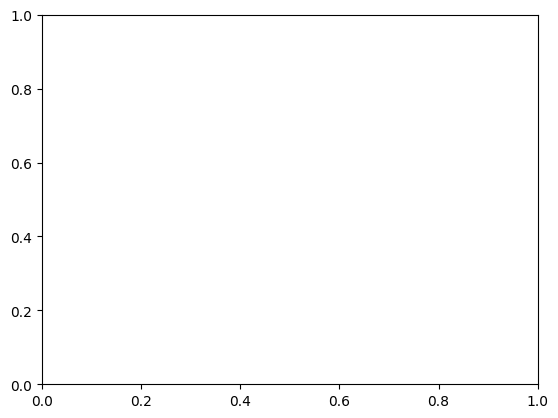

In [23]:

# Read data from Kafka and perform real-time visualization
def read_from_kafka():
    # Create a Streamlit app
    st.title("Real-Time Network Traffic Analysis")

    # Create a plot to visualize processed data
    fig, ax = plt.subplots()

    # Initialize an empty list to store processed data and event times
    processed_data = []
    event_times = []

    # Function to process incoming Kafka messages and update the plot
    def process_message(message):
        nonlocal processed_data, event_times
        if message is None:
            return
        if message.error():
            if message.error().code() == KafkaError._PARTITION_EOF:
                return
            else:
                print(f"Error: {message.error()}")
                return

        value = message.value().decode('utf-8')
        data = value.split(',')
        source_ip = data[0]
        destination_ip = data[1]
        bytes_sent = int(data[2])
        event_time = datetime.now()

        row = (source_ip, destination_ip, bytes_sent, event_time)
        df = spark.createDataFrame([row], schema=schema)

        # Perform window-based aggregations
        aggregated_df = df \
            .groupBy("source_ip") \
            .agg(sum("bytes_sent").alias("total_bytes_sent")) \
            .orderBy(desc("total_bytes_sent"))

        # Convert the aggregated DataFrame to JSON
        json_data = aggregated_df.select(to_json(struct("*")).alias("value")).first().value

        # Publish processed data to Kafka topic
        producer.produce(processed_topic, value=json_data.encode('utf-8'))

        # Wait for the message to be delivered to Kafka
        producer.flush()

        # Process the Kafka message and update the plot
        processed_data.append(bytes_sent)
        event_times.append(event_time)
        ax.clear()
        ax.plot(event_times, processed_data)
        ax.set_xlabel("Event Time")
        ax.set_ylabel("Processed Data")
        st.pyplot(fig)

    # Continuously read messages from Kafka topic
    while True:
        message = consumer.poll(1.0)

        if message is None:
            continue

        if message.error():
            if message.error().code() == KafkaError._PARTITION_EOF:
                continue
            else:
                print(f"Error: {message.error()}")
                break

        process_message(message)

# Run the Streamlit app
read_from_kafka()

# Wait for the streaming to finish
spark.streams.awaitAnyTermination()